In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy.signal as signal
import xarray as xr

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from utils.data_reading.sound_data.station import StationsCatalog

In [27]:
# Choix des variables
station_name = "MAHY41" # Select the station
depth_choice = 1300 # Select a depth (m) for the hydrology data (e.g. the SOFAR canal)
frequency = 10 # Select a frequency (Hz) at which you want to know the median amplitude

# Chargement des données
sys.path.append("/home/imonge/PycharmProjects/PythonProject/toolbox/src")

catalog_path = "/media/imonge/CORSAIR"  # Path of the hard drive containing MAHY data
stations = StationsCatalog(catalog_path)
station = stations.by_name(station_name)[0]  # this will contain metadata about the selected station
manager = station.get_manager()  # this will enable to read data from the selected station

hydro_data = xr.open_dataset("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/hydro_1/h1_total_time.nc") # Path of a directory containing the hydrology data (copernicus) for the station selected

In [6]:
# Prendre les dates du csv -> MAHY_modif.csv car j'ai modifié les dates de MAHY43 et MAHY44 qui étaient incorrectes
cat_info = pd.read_csv(catalog_path + '/MAHY/MAHY_modif.csv', parse_dates=['date_start', 'date_end'])
cat_info.set_index('station_name', inplace=True)
cat_info["date_start"] = pd.to_datetime(cat_info["date_start"])
cat_info["date_end"] = pd.to_datetime(cat_info["date_end"])
#cat_info.loc["MAHY41"] -> Pour visualiser les infos d'une station

In [47]:
# Erreur avec le téléchargement des psds pour MAHY41
# LTAS & vitesse du courant
date_start = datetime.datetime(2023,9,20,11,17,15)  # exemple : début le 10/10/21 à 5h30 et 25s
date_end = datetime.datetime(2024,9,27,5,38,24)
step = datetime.timedelta(seconds=3600)  # on lit les données par segments d'une heure
n_steps = (date_end-date_start)/step  # nombre de segments à calculer, attention c'est un nombre flottant
n_steps = int(n_steps)  # on transforme le nombre flottant en nombre entier
psds = []  # liste des psd de chaque segment, on va la remplir segment par segment

for i in range(n_steps):
    segment_start = date_start + i * step  # début du ième segment
    segment_end = date_start + (i+1) * step   # fin du ième segment
    data = manager.get_segment(segment_start, segment_end)
    psd_frequencies, psd = signal.welch(data, fs=240, nperseg=1024)  # fs est la fréquence d’échantillonnage, nperseg le nombre de points utilisés par transformée de Fourier. La résolution fréquentielle du résultats est 240/256 Hz
    psds.append(psd)

np.save(station.name + ".npy", psds)

0-length data fetched for files range(67, 68) from date 2023-10-08 16:17:15 to 2023-10-08 17:17:14.990000 (station MAHY41)
0-length data fetched for files range(67, 68) from date 2023-10-08 17:17:15 to 2023-10-08 18:17:14.990000 (station MAHY41)
0-length data fetched for files range(67, 68) from date 2023-10-08 18:17:15 to 2023-10-08 19:17:14.990000 (station MAHY41)


/home/imonge/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/imonge/PycharmProjects/PythonProject/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: negative dimensions are not allowed

In [7]:
# Changement de répertoire de travail sinon il va chercher dans src/notebooks/demo et non dans src/data_mahy (où j'ai enregistré les MAHY.npy)
os.getcwd()
os.chdir("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_mahy")

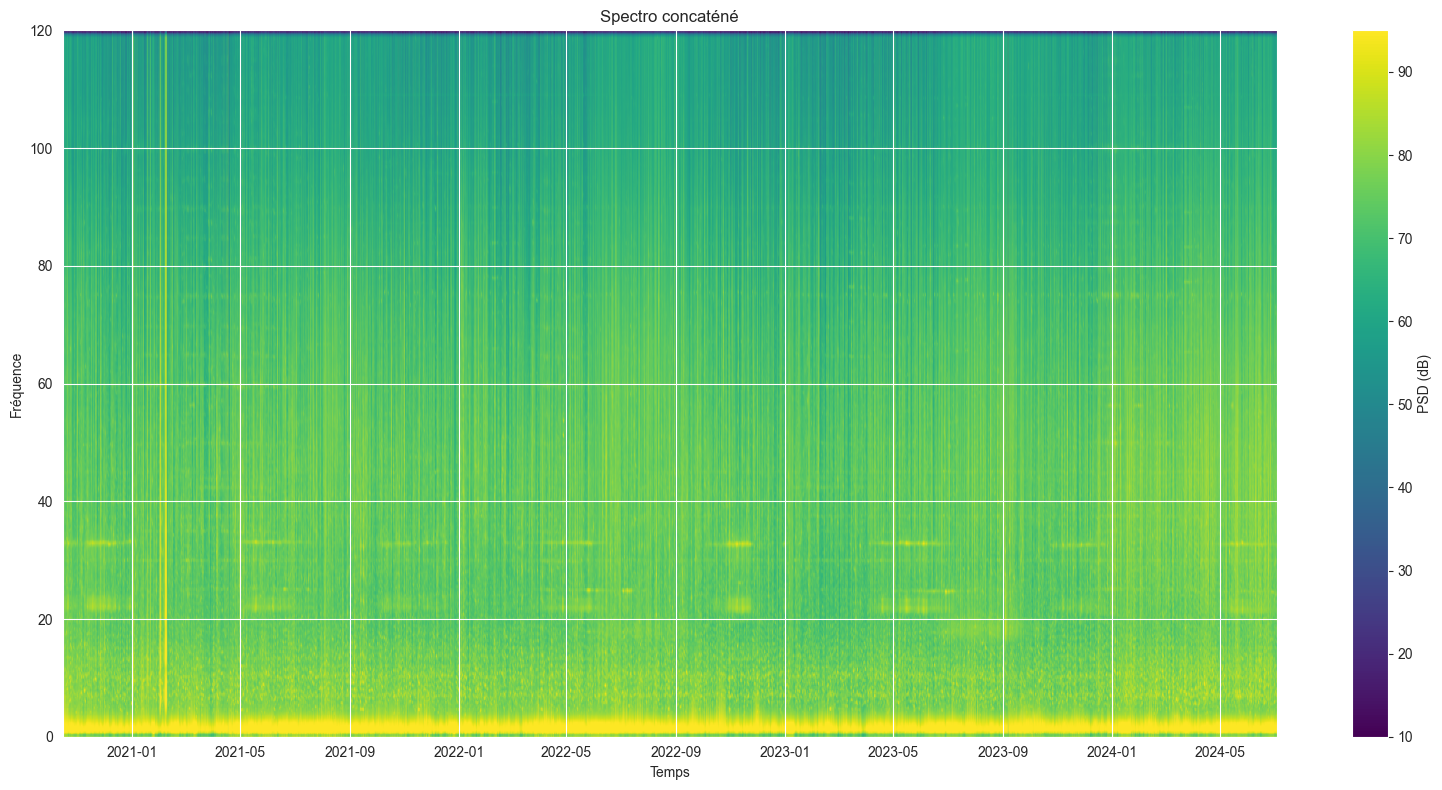

In [8]:
# Sélection des stations
selected_stations = ["MAHY02", "MAHY12", "MAHY22", "MAHY32", "MAHY42"]

# Liste pour stocker les psds
psds_all = []

# Boucle pour stations sélectionnées
for station in selected_stations:
    psds = np.load(f"{station}.npy")
    psds_all.append(psds)


date_start = cat_info["date_start"].loc[selected_stations[0]]
date_end = cat_info["date_end"].loc[selected_stations[-1]]

# Concaténation
final_psd = np.vstack(psds_all)

plt.figure(figsize=(16,8))
plt.imshow(10*np.log10(final_psd.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(date_start, date_end, 0, 120), vmin=10, vmax=95)
plt.colorbar(label="PSD (dB)")
plt.title("Spectro concaténé")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

/tmp/ipykernel_46815/2643718316.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_46815/2643718316.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


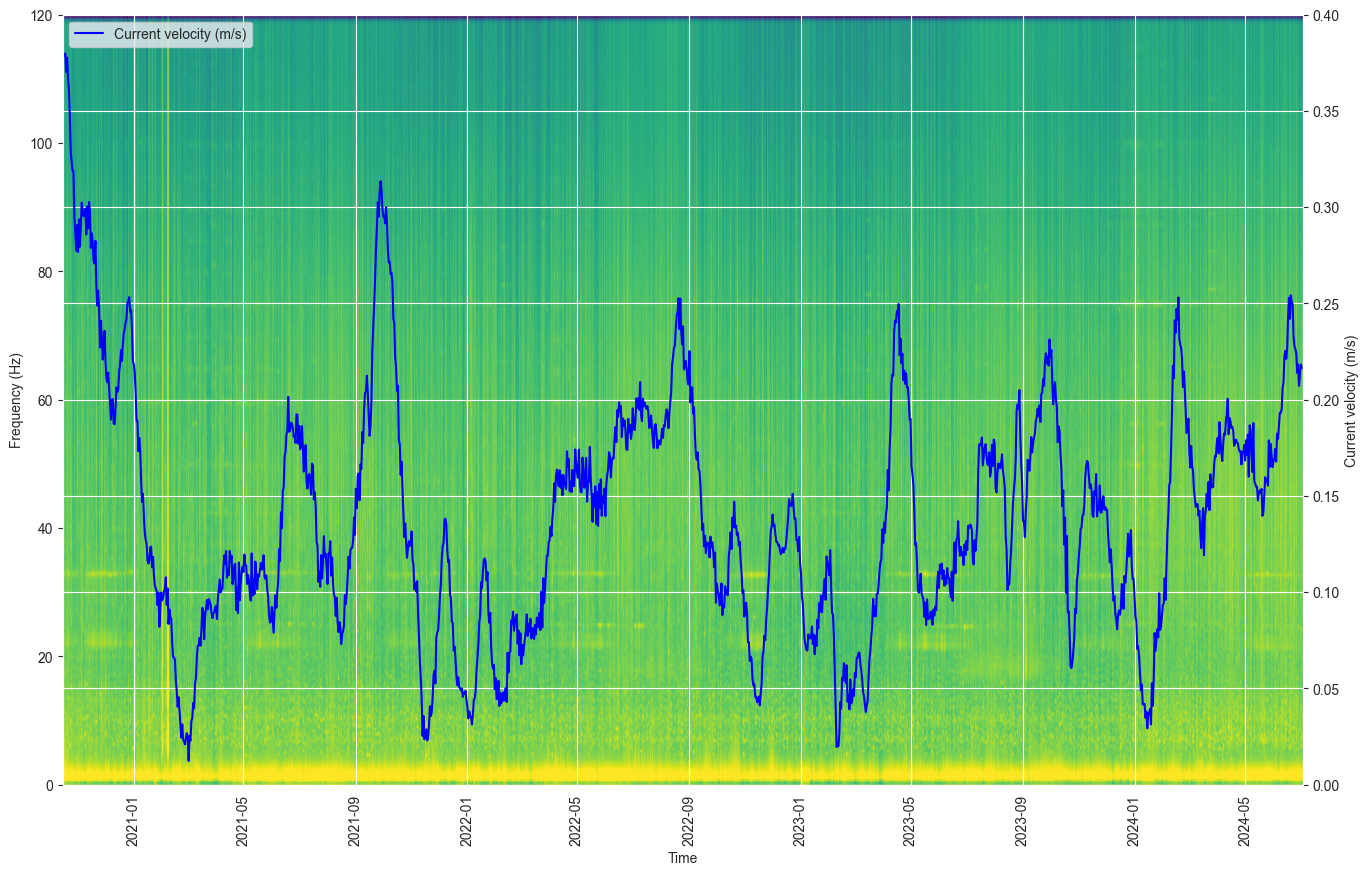

In [9]:
# Spectrogram with current velocity
fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for current speed
sp = ax.imshow(10*np.log10(final_psd.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(date_start, date_end, 0, 120), vmin=10, vmax=95)

t = pd.to_datetime(hydro_data["time"])
mask = (t>date_start) & (t<date_end) # Filter to only select the campaign dates

depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice)) # Finds the index in the dataset corresponding to the depth chosen
uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
vo = np.array(hydro_data["vo"][:,depth_index]).flatten()

velocity_magnitude = np.sqrt(uo**2+vo**2)[mask] # Current velocity
ax1.plot(t[mask], velocity_magnitude,label="Current velocity (m/s)", color="blue")
ax1.set_ylim(0,0.4) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

ax.set_xlabel("Time")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Current velocity (m/s)")
ax1.legend(loc="upper left")

fig.show()

/tmp/ipykernel_46815/3831381502.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_46815/3831381502.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


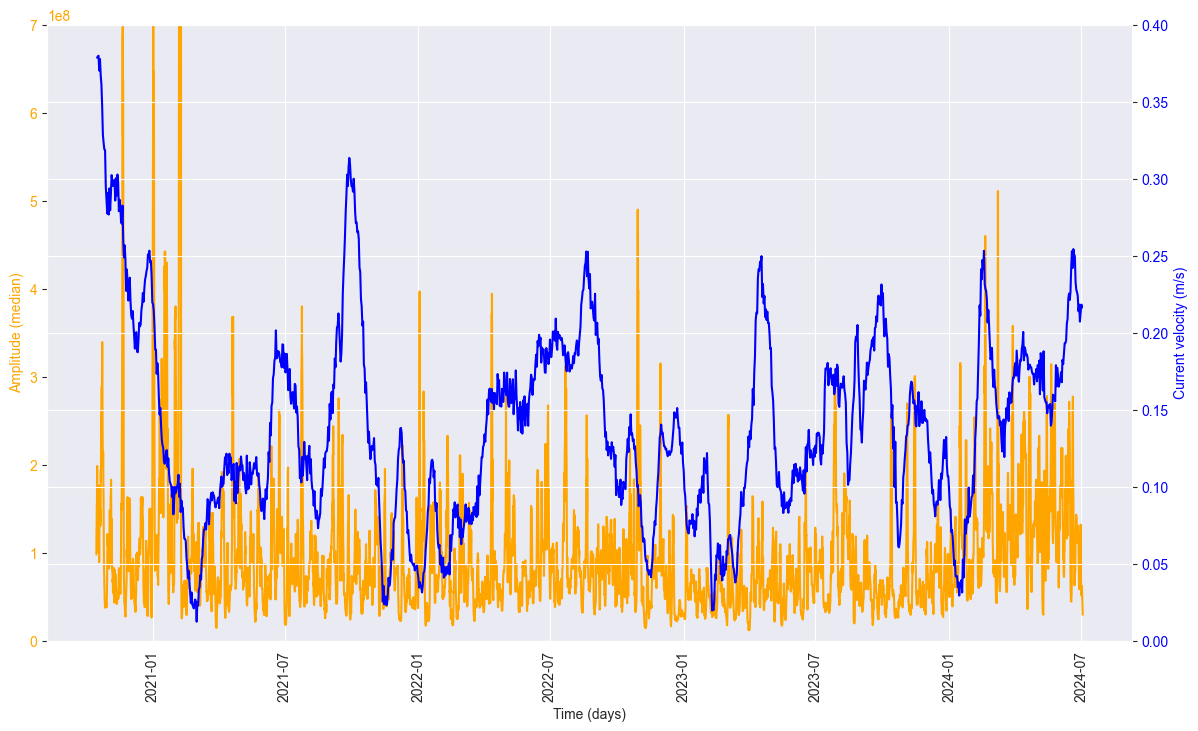

In [28]:
# Amplitude for a given freqeuncy & current velocity
frequency_resolution = 240/1024
frequency_index = int(frequency/frequency_resolution)
psds = np.array(final_psd)
amplitude = psds[:,frequency_index]

amplitude_steps = 31486
t_amplitude = pd.date_range(
    start=date_start,
    end=date_end,
    periods=amplitude_steps)

amplitude_filt = medfilt(amplitude, kernel_size=51)

fig, ax = plt.subplots(figsize = (14,8))


ax.plot(t_amplitude, amplitude_filt, color="orange", label="Amplitude (median)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Amplitude (median)", color="orange")
ax.tick_params(axis='y', labelcolor='orange')
#ax.plot(t_amplitude, amplitude, color="red", label="Amplitude")
ax.set_ylim(0,0.07e10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the amplitude

ax1 = ax.twinx()
ax1.plot(t[mask], velocity_magnitude, color="blue", label="Current velocity (m/s)")
ax1.set_ylim(0,0.4) #limites ax1
ax1.set_ylabel("Current velocity (m/s)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

fig.show()

In [29]:
# Test the correlation between the amplitude and the current velocity
amplitude_filt = medfilt(amplitude, kernel_size=51)
f = interp1d(pd.to_numeric(t[mask]), velocity_magnitude, bounds_error=False)(pd.to_numeric(t_amplitude))
nanmask = ~np.isnan(f) # remove nan values
np.corrcoef(f[nanmask], amplitude_filt[nanmask])

array([[1.        , 0.05415074],
       [0.05415074, 1.        ]])

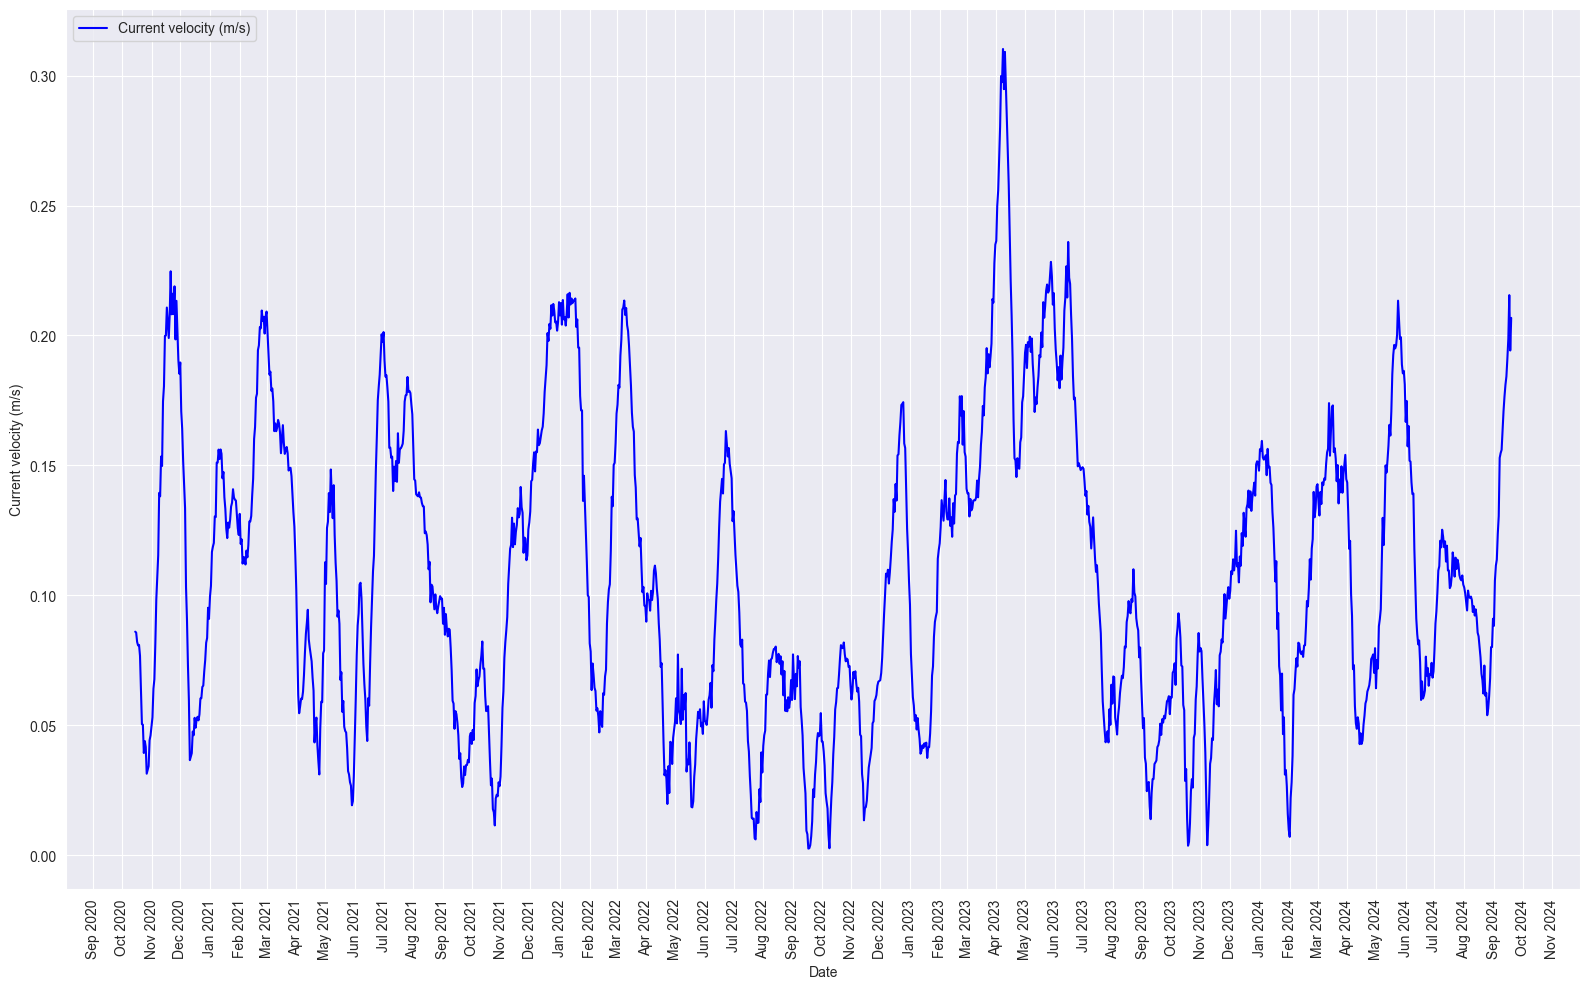

In [52]:
# Current velocity in time (independent from above)

depth_choice = 1300

hydro_data = xr.open_dataset("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/hydro_4/h4_total_time.nc") # Path of a directory containing the hydrology data (copernicus) for the station selected
date_start_current = datetime.datetime(2020,10,14,9,17,51)  # exemple : début le 10/10/21 à 5h30 et 25s
date_end_current = datetime.datetime(2024,9,19,11,30,5)

time_data = hydro_data["time"].values
time_data = np.array([np.datetime64(t).astype('datetime64[s]').astype(datetime.datetime) for t in time_data])

mask = (time_data >= date_start_current) & (time_data <= date_end_current)


depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice)) # Finds the index in the dataset corresponding to the depth chosen
uo = np.array(hydro_data["uo"][:,depth_index])[mask].flatten()
vo = np.array(hydro_data["vo"][:,depth_index])[mask].flatten()

velocity_magnitude = np.sqrt(uo**2+vo**2) # Current velocity
time_selected = time_data[mask]

plt.figure(figsize=(16,10))
plt.plot(time_selected, velocity_magnitude,label="Current velocity (m/s)", color="blue")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel("Date")
plt.ylabel("Current velocity (m/s)")
plt.xticks(rotation=90)
plt.legend(loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()
